In [1]:
'''
Things which can go wrong:
-Kernel size of 3 instead of 4 in second layer of prep network.
-Learning Rate Scheduler.
-Increasing Batch Size OR reducing dataset size.
'''

'\nThings which can go wrong:\n-Kernel size of 3 instead of 4 in second layer of prep network.\n-Learning Rate Scheduler.\n-Increasing Batch Size OR reducing dataset size.\n'

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchviz import make_dot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/talha/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
%matplotlib inline

In [3]:
dataset_path = '../tiny-imagenet-200/MultiImageSteganography'
train_csv = 'train_dataset.csv'
valid_csv = 'validation_dataset.csv'
train_folder = 'train/'
validation_folder = 'valid/'

In [4]:
IMG_SIZE = 64
LEARNING_RATE  = 0.001
COVER_LOSS_WEIGHT = 1
SECRET_LOSS_WEIGHT = 1
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 1
EPOCHS = 1000
DECODER_LOSS_WEIGHT = 1

In [5]:
transformations = {
    'train_transforms':torchvision.transforms.Compose([torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),torchvision.transforms.ToTensor()]),
    'valid_transforms':torchvision.transforms.Compose([torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),torchvision.transforms.ToTensor()])
}

class SteganoDataset(torch.utils.data.Dataset):
    def __init__(self,dataset_csv,transforms,type_of_dataset,size='complete'):
        self.dataset = pd.read_csv(dataset_csv)
        self.dataset = self.dataset.reset_index(drop=True)
        if size !='complete':
            self.dataset = self.dataset[:4]
        self.transforms = transforms
        self.type = type_of_dataset
    
    def __getitem__(self,index):
        cover_image = self.dataset.iloc[index]['cover_image']
        secret_image1 = self.dataset.iloc[index]['secret_image_1']
        secret_image2 = self.dataset.iloc[index]['secret_image_2']
        secret_image3 = self.dataset.iloc[index]['secret_image_3']
        
        cover_image = Image.open(os.path.join(dataset_path,self.type,cover_image))
        secret_image1 = Image.open(os.path.join(dataset_path,self.type,secret_image1))
        secret_image2 = Image.open(os.path.join(dataset_path,self.type,secret_image2))
        secret_image3 = Image.open(os.path.join(dataset_path,self.type,secret_image3))
        
        transformed_cover_image = self.transforms(cover_image)
        transformed_secret_image_1 = self.transforms(secret_image1)
        transformed_secret_image_2 = self.transforms(secret_image2)
        transformed_secret_image_3 = self.transforms(secret_image3)
        
        if self.type == 'train':
            return {
                'cover_image':transformed_cover_image,
                'secret_image_1':transformed_secret_image_1,
                'secret_image_2':transformed_secret_image_2,
                'secret_image_3':transformed_secret_image_3
            }
        else:
            return {
                'cover_image':transformed_cover_image,
                'secret_image_1':transformed_secret_image_1,
                'secret_image_2':transformed_secret_image_2,
                'secret_image_3':transformed_secret_image_3
            }
    
    def __len__(self):
        return len(self.dataset)

In [6]:
class PrepNetwork1(nn.Module):
    def __init__(self):
        super(PrepNetwork1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
    
    def forward(self,secret_image):
        output_1 = F.relu(self.conv1(secret_image))
        output_2 = F.relu(self.conv2(secret_image))
        output_3 = F.relu(self.conv3(secret_image))
        
        concatenated_image = torch.cat([output_1,output_2,output_3],dim=1)
        output_4 = F.relu(self.conv4(concatenated_image))
        output_5 = F.relu(self.conv5(concatenated_image))
        output_6 = F.relu(self.conv6(concatenated_image))
        
        final_concat_image = torch.cat([output_4,output_5,output_6],dim=1)
        return final_concat_image
    
class PrepNetwork2(nn.Module):
    def __init__(self):
        super(PrepNetwork2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
    
    def forward(self,secret_image):
        output_1 = F.relu(self.conv1(secret_image))
        output_2 = F.relu(self.conv2(secret_image))
        output_3 = F.relu(self.conv3(secret_image))
        
        concatenated_image = torch.cat([output_1,output_2,output_3],dim=1)
        output_4 = F.relu(self.conv4(concatenated_image))
        output_5 = F.relu(self.conv5(concatenated_image))
        output_6 = F.relu(self.conv6(concatenated_image))
        
        final_concat_image = torch.cat([output_4,output_5,output_6],dim=1)
        return final_concat_image
    
class PrepNetwork3(nn.Module):
    def __init__(self):
        super(PrepNetwork3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
    
    def forward(self,secret_image):
        output_1 = F.relu(self.conv1(secret_image))
        output_2 = F.relu(self.conv2(secret_image))
        output_3 = F.relu(self.conv3(secret_image))
        
        concatenated_image = torch.cat([output_1,output_2,output_3],dim=1)
        output_4 = F.relu(self.conv4(concatenated_image))
        output_5 = F.relu(self.conv5(concatenated_image))
        output_6 = F.relu(self.conv6(concatenated_image))
        
        final_concat_image = torch.cat([output_4,output_5,output_6],dim=1)
        return final_concat_image

class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=198,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=198,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=198,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv10 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv11 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv12 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv13 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv14 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv15 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=65,out_channels=3,kernel_size=(3,3),stride=1,padding=1)
        
    def forward(self,secret_image_1,secret_image_2,secret_image_3,cover_image):
        concatenated_secrets = torch.cat([cover_image,secret_image_1,secret_image_2,secret_image_3],dim=1)
        
        output_1 = F.relu(self.conv1(concatenated_secrets))
        output_2 = F.relu(self.conv2(concatenated_secrets))
        output_3 = F.relu(self.conv3(concatenated_secrets))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        output_10 = F.relu(self.conv10(concat_3))
        output_11 = F.relu(self.conv11(concat_3))
        output_12 = F.relu(self.conv12(concat_3))
        concat_4 = torch.cat([output_10,output_11,output_12],dim=1)
        
        output_13 = F.relu(self.conv13(concat_4))
        output_14 = F.relu(self.conv14(concat_4))
        output_15 = F.relu(self.conv15(concat_4))
        concat_5 = torch.cat([output_13,output_14,output_15],dim=1)
        
        output_converted_image = F.relu(self.final_layer(concat_5))
        
        return output_converted_image
        

In [7]:
class Encoder(nn.Module):
    def __init__(self,prep_network_1,prep_network_2,prep_network_3,hiding_network):
        super(Encoder, self).__init__()
        self.prep_network1 = prep_network_1
        self.prep_network2 = prep_network_2
        self.prep_network3 = prep_network_3
        self.hiding_network = hiding_network
    
    def forward(self,cover_image,secret_image_1,secret_image_2,secret_image_3):
        encoded_secret_image_1 = self.prep_network1(secret_image_1)
        encoded_secret_image_2 = self.prep_network2(secret_image_2)
        encoded_secret_image_3 = self.prep_network3(secret_image_3)
        
        hidden_image = self.hiding_network(encoded_secret_image_1,
                                           encoded_secret_image_2,
                                           encoded_secret_image_3,
                                           cover_image
                                          )
#         hidden_image = (0.01**0.5)*torch.randn(hidden_image.size(),device=device)
        return hidden_image

In [8]:
class RevealNetwork1(nn.Module):
    def __init__(self):
        super(RevealNetwork1,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv10 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv11 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv12 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv13 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv14 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv15 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=65,out_channels=3,kernel_size=(3,3),stride=1,padding=1)    
    
    def forward(self,hidden_image):
        
        output_1 = F.relu(self.conv1(hidden_image))
        output_2 = F.relu(self.conv2(hidden_image))
        output_3 = F.relu(self.conv3(hidden_image))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        output_10 = F.relu(self.conv10(concat_3))
        output_11 = F.relu(self.conv11(concat_3))
        output_12 = F.relu(self.conv12(concat_3))
        concat_4 = torch.cat([output_10,output_11,output_12],dim=1)
        
        output_13 = F.relu(self.conv13(concat_4))
        output_14 = F.relu(self.conv14(concat_4))
        output_15 = F.relu(self.conv15(concat_4))
        concat_5 = torch.cat([output_13,output_14,output_15],dim=1)
        
        output_revealed_image = F.relu(self.final_layer(concat_5))
        
        return output_revealed_image
    
class RevealNetwork2(nn.Module):
    def __init__(self):
        super(RevealNetwork2,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv10 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv11 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv12 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv13 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv14 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv15 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=65,out_channels=3,kernel_size=(3,3),stride=1,padding=1)    
    
    def forward(self,hidden_image):
        
        output_1 = F.relu(self.conv1(hidden_image))
        output_2 = F.relu(self.conv2(hidden_image))
        output_3 = F.relu(self.conv3(hidden_image))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        output_10 = F.relu(self.conv10(concat_3))
        output_11 = F.relu(self.conv11(concat_3))
        output_12 = F.relu(self.conv12(concat_3))
        concat_4 = torch.cat([output_10,output_11,output_12],dim=1)
        
        output_13 = F.relu(self.conv13(concat_4))
        output_14 = F.relu(self.conv14(concat_4))
        output_15 = F.relu(self.conv15(concat_4))
        concat_5 = torch.cat([output_13,output_14,output_15],dim=1)
        
        output_revealed_image = F.relu(self.final_layer(concat_5))
        
        return output_revealed_image

class RevealNetwork3(nn.Module):
    def __init__(self):
        super(RevealNetwork3,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv10 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv11 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv12 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv13 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv14 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv15 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=65,out_channels=3,kernel_size=(3,3),stride=1,padding=1)    
    
    def forward(self,hidden_image):
        output_1 = F.relu(self.conv1(hidden_image))
        output_2 = F.relu(self.conv2(hidden_image))
        output_3 = F.relu(self.conv3(hidden_image))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        output_10 = F.relu(self.conv10(concat_3))
        output_11 = F.relu(self.conv11(concat_3))
        output_12 = F.relu(self.conv12(concat_3))
        concat_4 = torch.cat([output_10,output_11,output_12],dim=1)
        
        output_13 = F.relu(self.conv13(concat_4))
        output_14 = F.relu(self.conv14(concat_4))
        output_15 = F.relu(self.conv15(concat_4))
        concat_5 = torch.cat([output_13,output_14,output_15],dim=1)
        
        output_revealed_image = F.relu(self.final_layer(concat_5))
        
        return output_revealed_image 

In [9]:
class Decoder(nn.Module):
    def __init__(self,reveal_network_1,reveal_network_2,reveal_network_3):
        super(Decoder, self).__init__()
        self.reveal_network_1 = reveal_network_1
        self.reveal_network_2 = reveal_network_2
        self.reveal_network_3 = reveal_network_3
    
    def forward(self,hidden_image):
        reveal_image_1 = self.reveal_network_1(hidden_image)
        reveal_image_2 = self.reveal_network_2(hidden_image)
        reveal_image_3 = self.reveal_network_3(hidden_image)
        return reveal_image_1,reveal_image_2,reveal_image_3

In [10]:
class SteganoModel(nn.Module):
    def __init__(self,encoder,decoder):
        super(SteganoModel,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self,cover_image,secret_image_1,secret_image_2,secret_image_3,hidden_image,mode):
        if mode == 'full':
            for param in self.encoder.parameters():
                param.requires_grad = True
            for param in self.decoder.parameters():
                param.requires_grad = False
            hidden_image = self.encoder(cover_image,secret_image_1,secret_image_2,secret_image_3)
            reveal_image_1,reveal_image_2,reveal_image_3 = self.decoder(hidden_image)
            return hidden_image,reveal_image_1,reveal_image_2,reveal_image_3
        elif mode == 'encoder':
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False
            hidden_image = self.encoder(cover_image,secret_image_1,secret_image_2,secret_image_3)
            return hidden_image
        elif mode == 'decoder':
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = True
            
            reveal_image1, reveal_image2,reveal_image3 = self.decoder(hidden_image)
            return reveal_image1, reveal_image2,reveal_image3

In [11]:
prep_1 = PrepNetwork1()
prep_2 = PrepNetwork2()
prep_3 = PrepNetwork3()
hiding_network = HidingNetwork()

encoder = Encoder(prep_1,prep_2,prep_3,hiding_network)

reveal_1 = RevealNetwork1()
reveal_2 = RevealNetwork2()
reveal_3 = RevealNetwork3()

decoder = Decoder(reveal_1,reveal_2,reveal_3)

model = SteganoModel(encoder,decoder)
model.to(device)

SteganoModel(
  (encoder): Encoder(
    (prep_network1): PrepNetwork1(
      (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv4): Conv2d(65, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(65, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv6): Conv2d(65, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (prep_network2): PrepNetwork2(
      (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv4): Conv2d(65, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(65, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [12]:
class SteganoLoss(nn.Module):
    def __init__(self,cover_weight,secret_weight):
        super(SteganoLoss,self).__init__()
        self.cover_weight = cover_weight
        self.secret_weight = secret_weight
        
    def forward(self,predicted_cover_image,cover_image,
               predicted_secret_image_1,secret_image_1,
               predicted_secret_image_2,secret_image_2,
               predicted_secret_image_3,secret_image_3):
    
        cover_loss = self.cover_weight*(F.mse_loss(predicted_cover_image,cover_image))
        secret_loss = self.secret_weight*(F.mse_loss(predicted_secret_image_1,secret_image_1)) + self.secret_weight*(F.mse_loss(predicted_secret_image_2,secret_image_2)) + self.secret_weight*(F.mse_loss(predicted_secret_image_3,secret_image_3)) 
        return cover_loss + secret_loss

class DecoderLoss(nn.Module):
    def __init__(self,decoder_loss_weight):
        super(DecoderLoss,self).__init__()
        self.decoder_loss_weight = decoder_loss_weight
    
    def forward(self,reveal_output1, reveal_output2,reveal_output3,secret_image_1,
                                            secret_image_2,secret_image_3):
        reveal1 = self.decoder_loss_weight*F.mse_loss(reveal_output1,secret_image_1)
        reveal2 = self.decoder_loss_weight*F.mse_loss(reveal_output2,secret_image_2)
        reveal3 = self.decoder_loss_weight*F.mse_loss(reveal_output3,secret_image_3)
        
        return reveal1 + reveal2 + reveal3

In [13]:
training_csv_path = os.path.join(dataset_path,train_csv)
validation_csv_path = os.path.join(dataset_path,valid_csv)

training_dataset = SteganoDataset(training_csv_path,transformations['train_transforms'],'train','complete')
valid_dataset = SteganoDataset(validation_csv_path,transformations['valid_transforms'],'valid')

train_data_loader = torch.utils.data.DataLoader(training_dataset, 
                                                batch_size = TRAIN_BATCH_SIZE, 
                                                shuffle=True,
                                               drop_last = True,
                                               num_workers = 0
                                               )
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, 
                                                batch_size = VALID_BATCH_SIZE, 
                                                shuffle=True,
                                                drop_last = True,
                                                num_workers = 0
                                               )

full_model_criterion = SteganoLoss(SECRET_LOSS_WEIGHT,COVER_LOSS_WEIGHT)

full_model_optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

decoder_criterion = DecoderLoss(DECODER_LOSS_WEIGHT)

In [14]:
def train(model,epochs,decoder_criterion,full_model_optimizer,full_model_criterion,learning_rate,training_iterator,valid_iterator,print_every=50):
    
    training_full_model_loss_list = []
    decoder_loss_list = []
    valid_loss_list = []
    
    for epoch in range(epochs):
        for index,training_dict in enumerate(training_iterator):
            cover_image = training_dict['cover_image']
            cover_image = cover_image.to(device)
            
            secret_image_1 = training_dict['secret_image_1']
            secret_image_1 = secret_image_1.to(device)
            
            secret_image_2 = training_dict['secret_image_2']
            secret_image_2 = secret_image_2.to(device)
            
            secret_image_3 = training_dict['secret_image_3']
            secret_image_3 = secret_image_3.to(device)
            
            full_model_optimizer.zero_grad()
            
            encoder_output = model(cover_image,secret_image_1,secret_image_2,secret_image_3,secret_image_3,'encoder')

            hidden_image,reveal_image_1,reveal_image_2,reveal_image_3 = model(cover_image,
                                                                 secret_image_1,
                                                                 secret_image_2,
                                                                 secret_image_3,secret_image_3,'full')
            
            full_model_loss = full_model_criterion(hidden_image,cover_image,
                             reveal_image_1,secret_image_1,
                             reveal_image_2,secret_image_2,
                             reveal_image_3,secret_image_3,
                            )
            full_model_loss.backward()
            full_model_optimizer.step()
            
            full_model_optimizer.zero_grad()
            reveal_output1, reveal_output2,reveal_output3 = model(cover_image,
                                                                 secret_image_1,
                                                                 secret_image_2,
                                                                 secret_image_3,encoder_output,'decoder')
            decoder_loss = decoder_criterion(reveal_output1, reveal_output2,reveal_output3,secret_image_1,
                                            secret_image_2,secret_image_3)
            
            decoder_loss.backward()
            full_model_optimizer.step()
            
        training_full_model_loss_list.append(full_model_loss)
        decoder_loss_list.append(decoder_loss)
        if epoch % print_every == 0:
            print("Training full model loss at {} epochs is: {}".format(epoch, full_model_loss))
            print("Training decoder loss at {} epochs is: {}".format(epoch, decoder_loss))
        
    return model, training_full_model_loss_list,decoder_loss_list

In [16]:
model, training_full_model_loss_list,decoder_loss_list = train(model,EPOCHS,decoder_criterion,full_model_optimizer,full_model_criterion,LEARNING_RATE,train_data_loader,valid_data_loader)

Training full model loss at 0 epochs is: 0.3847321569919586
Training decoder loss at 0 epochs is: 0.34206676483154297
Training full model loss at 50 epochs is: 0.06924165040254593
Training decoder loss at 50 epochs is: 0.04892994463443756
Training full model loss at 100 epochs is: 0.05085470527410507
Training decoder loss at 100 epochs is: 0.03802792355418205
Training full model loss at 150 epochs is: 0.03637094795703888
Training decoder loss at 150 epochs is: 0.02620428055524826
Training full model loss at 200 epochs is: 0.026935387402772903
Training decoder loss at 200 epochs is: 0.0216311477124691
Training full model loss at 250 epochs is: 0.02079840563237667
Training decoder loss at 250 epochs is: 0.01709096133708954
Training full model loss at 300 epochs is: 0.020048968493938446
Training decoder loss at 300 epochs is: 0.0165126733481884
Training full model loss at 350 epochs is: 0.02106284722685814
Training decoder loss at 350 epochs is: 0.017230628058314323
Training full model lo

In [15]:
# torch.save(model,'./model_1000.pkl')
# model = torch.load('./models/model_1000.pkl',map_location=torch.device('cpu'))

In [16]:
data = next(iter(valid_data_loader))

cover_image = data['cover_image']
cover_image = cover_image.to(device)

secret_image_1 = data['secret_image_1']
secret_image_1 = secret_image_1.to(device)

secret_image_2 = data['secret_image_2']
secret_image_2 = secret_image_2.to(device)

secret_image_3 = data['secret_image_3']
secret_image_3 = secret_image_3.to(device)

model.eval()
    
hidden_image,reveal_image_1,reveal_image_2,reveal_image_3 = model(cover_image,
                                                                 secret_image_1,
                                                                 secret_image_2,
                                                                 secret_image_3,secret_image_3,'full')

In [18]:
make_dot(hidden_image).render('hidden_image',format='png')

'hidden_image.png'

In [19]:
make_dot(reveal_image_1).render('reveal_image',format='png')

'reveal_image.png'

In [19]:
def plot_loss(loss_list,title):
    plt.plot(loss_list)
    plt.show()

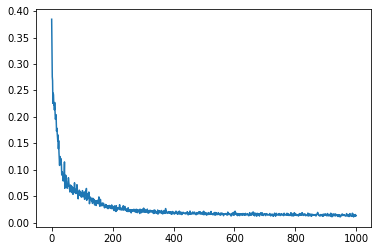

In [30]:
plot_loss(training_full_model_loss_list)

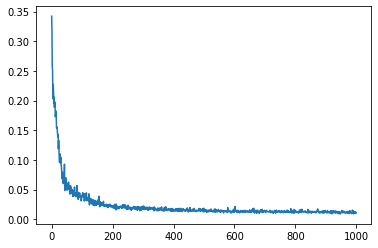

In [31]:
plot_loss(decoder_loss_list)

In [20]:
def predict(model,iterator):
    predict_dict = next(iter(iterator))
    cover_image = predict_dict['cover_image']
    cover_image = cover_image.to(device)

    secret_image_1 = predict_dict['secret_image_1']
    secret_image_1 = secret_image_1.to(device)

    secret_image_2 = predict_dict['secret_image_2']
    secret_image_2 = secret_image_2.to(device)

    secret_image_3 = predict_dict['secret_image_3']
    secret_image_3 = secret_image_3.to(device)
    
    model.eval()
    
    hidden_image,reveal_image_1,reveal_image_2,reveal_image_3 = model(cover_image,
                                                                 secret_image_1,
                                                                 secret_image_2,
                                                                 secret_image_3,secret_image_3,'full')
    
    cover_image = cover_image * 255
    secret_image_3 = secret_image_3 * 255
    secret_image_1 = secret_image_1 * 255
    secret_image_2 = secret_image_2 * 255
    
    hidden_image = hidden_image * 255
    reveal_image_1 = reveal_image_1 * 255
    reveal_image_2 = reveal_image_2 * 255
    reveal_image_3 = reveal_image_3 * 255
    
    secret_image_1 = secret_image_1.to(torch.device('cpu'))
    secret_image_2 = secret_image_2.to(torch.device('cpu'))
    secret_image_3 = secret_image_3.to(torch.device('cpu'))
    cover_image = cover_image.to(torch.device('cpu'))
    
    reveal_image_1 = reveal_image_1.to(torch.device('cpu'))
    reveal_image_2 = reveal_image_2.to(torch.device('cpu'))
    reveal_image_3 = reveal_image_3.to(torch.device('cpu'))
    hidden_image = hidden_image.to(torch.device('cpu'))
    
    secret_image_1 = secret_image_1.detach().to(torch.long)
    secret_image_2 = secret_image_2.detach().to(torch.long)
    secret_image_3 = secret_image_3.detach().to(torch.long)
    cover_image = cover_image.detach().to(torch.long)

    hidden_image = hidden_image.detach().to(torch.long)
    reveal_image_1 = reveal_image_1.detach().to(torch.long)
    reveal_image_2 = reveal_image_2.detach().to(torch.long)
    reveal_image_3 = reveal_image_3.detach().to(torch.long)
    
    
    hidden_image_grid = torchvision.utils.make_grid(hidden_image,nrow=4)
    reveal_image_1_grid = torchvision.utils.make_grid(reveal_image_1,nrow=4)
    reveal_image_2_grid = torchvision.utils.make_grid(reveal_image_2,nrow=4)
    reveal_image_3_grid = torchvision.utils.make_grid(reveal_image_3,nrow=4)
    
    cover_image_grid = torchvision.utils.make_grid(cover_image,nrow=4)
    secret_image_1_grid = torchvision.utils.make_grid(secret_image_1,nrow=4)
    secret_image_2_grid = torchvision.utils.make_grid(secret_image_2,nrow=4)
    secret_image_3_grid = torchvision.utils.make_grid(secret_image_3,nrow=4)
    return {
        'cover_image_grid':cover_image_grid,
        'secret_image_1_grid':secret_image_1_grid,
        'secret_image_2_grid':secret_image_2_grid,
        'secret_image_3_grid':secret_image_3_grid,
        'hidden_image_grid':hidden_image_grid,
        'reveal_image_1_grid':reveal_image_1_grid,
        'reveal_image_2_grid':reveal_image_2_grid,
        'reveal_image_3_grid':reveal_image_3_grid
    }

In [35]:
grids = predict(model,valid_data_loader)

In [52]:
def plot(grids):
    plt.figure(figsize=(15,8))
    
    plt.subplot(241)
    plt.title('Cover Image')
    plt.imshow(grids['cover_image_grid'].permute(1,2,0))

    plt.subplot(242)
    plt.title('Secret Image 1')
    plt.imshow(grids['secret_image_1_grid'].permute(1,2,0))

    plt.subplot(243)
    plt.title('Secret Image 2')
    plt.imshow(grids['secret_image_2_grid'].permute(1,2,0))

    plt.subplot(244)
    plt.title('Secret Image 3')
    plt.imshow(grids['secret_image_3_grid'].permute(1,2,0))

    plt.subplot(245)
    plt.title('Hidden Image')
    plt.imshow(grids['hidden_image_grid'].permute(1,2,0))

    plt.subplot(246)
    plt.title('Reveal Image 1')
    plt.imshow(grids['reveal_image_1_grid'].permute(1,2,0))

    plt.subplot(247)
    plt.title('Reveal Image 2')
    plt.imshow(grids['reveal_image_2_grid'].permute(1,2,0))

    plt.subplot(248)
    plt.title('Reveal Image 3')
    plt.imshow(grids['reveal_image_3_grid'].permute(1,2,0))

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


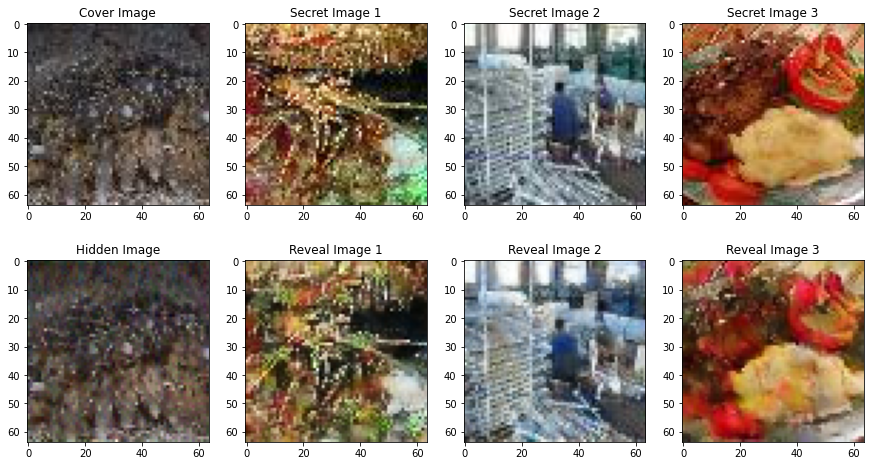

In [53]:
plot(grids)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


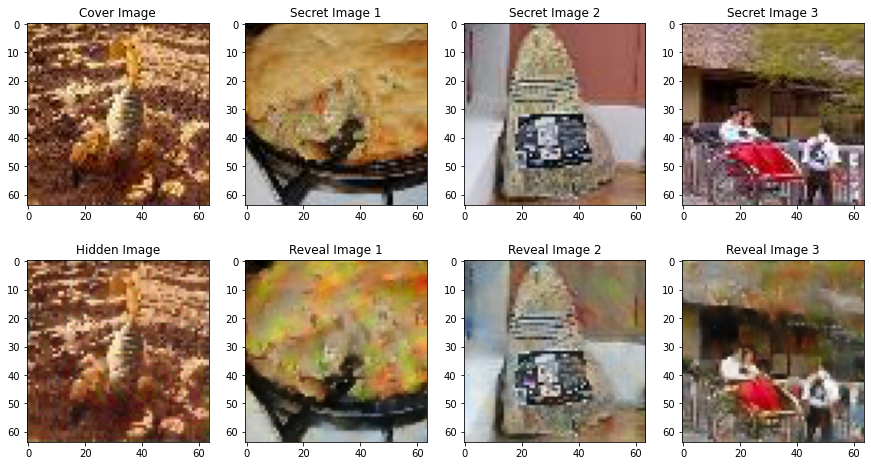

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


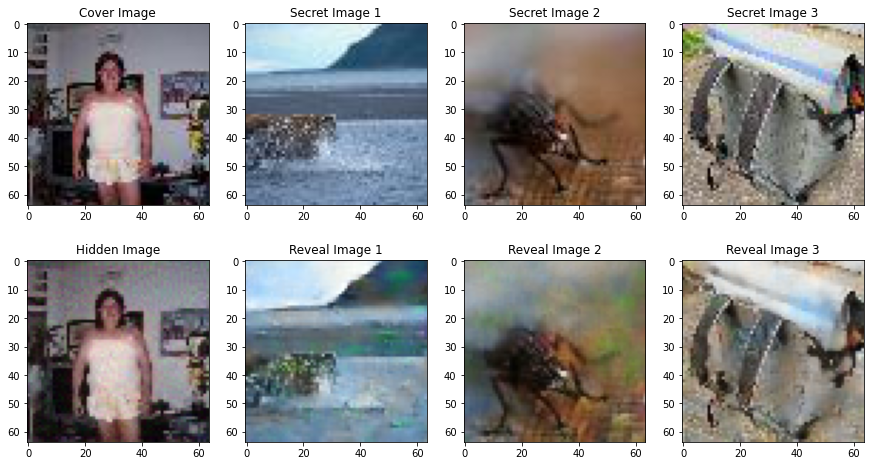

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


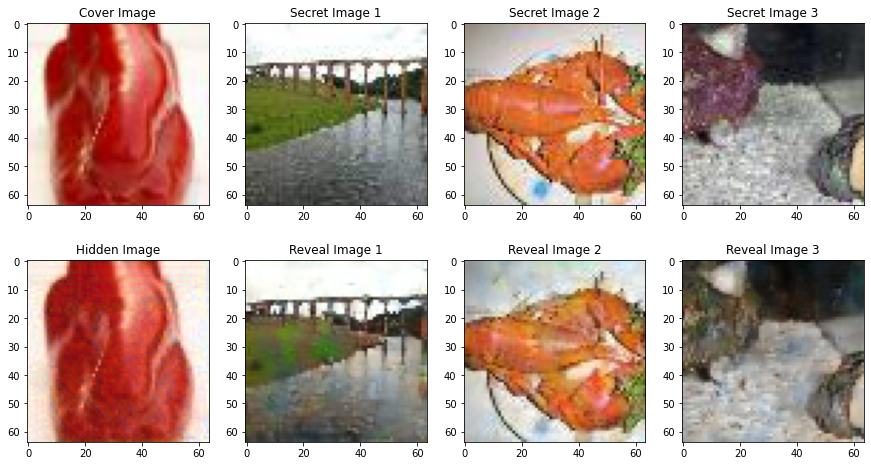

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


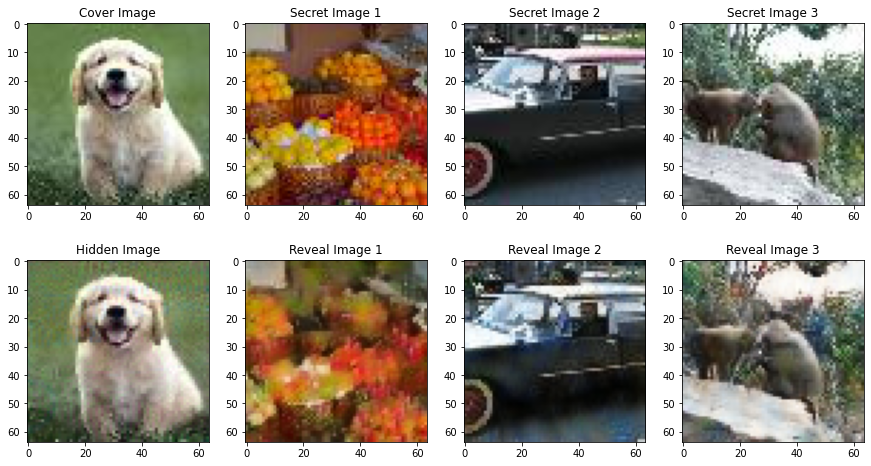

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


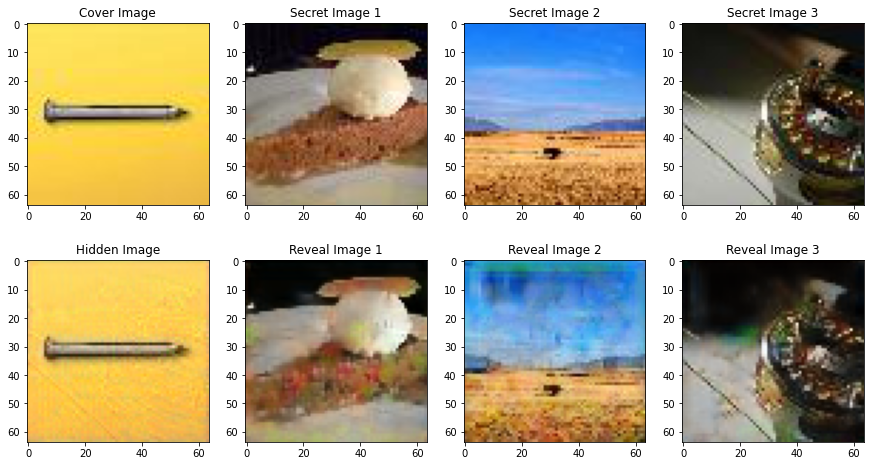

In [55]:
for i in range(5):
    grids = predict(model,valid_data_loader)
    plot(grids)